# CRISMIS GSOC Project - Notebook 1 of 2

## Step 1 – Retrieving and Plotting Image Files

In [1]:
import os
from os import path
import re
import sys
import wget
import time
import requests
import subprocess
import numpy as np
from PIL import Image
from bs4 import BeautifulSoup

rootDirectory = os.getcwd()
cwd = os.getcwd()

year = int()
DOY = int()

In [2]:
def return_parent_urls(root_url): # Generate a list of all main links in data archive
    url = root_url
    r = requests.get(url)
    urls = list()
    soup = BeautifulSoup(r.content,'html.parser') 
    for link in soup.find_all('a'):
        urls.append(url + link.get('href'))
    return urls[5:]

def generate_url(year, DOY): # Fetch url of directory corresponding to given year and DOY
    url = 'https://pdsimage2.wr.usgs.gov/archive/mess-e_v_h-mdis-2-edr-rawdata-v1.0/MSGRMDS_1001/DATA/{}_{}/'.format(str(year), str(DOY))
    return url

def fetch_all_img_links_from_url(url): # Fetch download links of all IMG Files on a page
    
    # create response object and parse with BeautifulSoup
    r = requests.get(url)
    soup = BeautifulSoup(r.content,'html.parser') 

    # find all links on web-page 
    links = soup.findAll('a') 

    # filter the link sending with .IMG 
    IMG_Links = [url + link['href'] for link in links if link['href'].endswith('IMG')]
    return(IMG_Links)

def create_file_list(path): # Create list of all IMG files in a given local directory
    fileList = list()
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".IMG"):
                 fileList.append(file)
    return fileList

def create_directory_for_img_files(year, DOY): # Creates a new local directory to store images of given year, DOY
    path = os.path.join(rootDirectory, '{}_{}'.format(str(year), str(DOY)))
    try:  
        os.mkdir(path)  
    except OSError as error:  
        print(error)
    
    return path
    
def change_directory(path):
    os.chdir(path)
    cwd = path
    
def download_img_files(IMG_Links, parallel_downloading=False): # Downloader(takes list of generated IMG Urls as input)
    if parallel_downloading == True:
        with open("link_file.txt", "w") as f:
            for link in IMG_Links:	
                f.write(link)
                f.write("\n")
        path = os.path.abspath("link_file.txt")
        print(path)
        subprocess.run(["parallel", "wget", "<", path])
    else:
        for i, link in enumerate(IMG_Links):
            file_name = link.split('/')[-1]
            if os.path.exists(file_name) != True:
                r = requests.get(link, stream = True)
                printProgressBar(0, len(IMG_Links), prefix = 'Progress:', suffix = 'Complete', length = 50)
                with open(file_name, 'wb') as f:
                    for chunk in r.iter_content(chunk_size = 1024*1024):
                        if chunk:
                            f.write(chunk)
        #         print("Downloaded {}".format(file_name))
                printProgressBar(i + 1, len(IMG_Links), prefix = 'Progress:', suffix = 'Complete', length = 50)
        
        print ("All files downloaded!")
    
def download_init(): # User interface for starting a download by providing year and DOY values
    global year
    global DOY
    year, DOY = input("Enter Year and DOY: ").split(" ")
    url = generate_url(year, DOY)
    IMG_Links = fetch_all_img_links_from_url(url)
    path = create_directory_for_img_files(year, DOY)
    change_directory(path)
    download_img_files(IMG_Links=IMG_Links, parallel_downloading=False) 
    #parallel_downloading should only be used if 'GNU Parallels' is installed on the system
    os.chdir("..")
    
def convert_img_jpg(filename): # Converts .IMG Files to .JPG files
    rawData  = open(filename, 'rb').read()

    # File size in bytes
    fs       = len(rawData)
    bitDepth = int(re.search("SAMPLE_BITS\s+=\s+(\d+)",str(rawData)).group(1))
    bytespp  = int(bitDepth/8)
    height   = int(re.search("LINES\s+=\s+(\d+)",str(rawData)).group(1))
    width    = int(re.search("LINE_SAMPLES\s+=\s+(\d+)",str(rawData)).group(1))
#     print(bitDepth,height,width)

    # Offset from start of file to image data - assumes image at tail end of file
    offset = fs - (width*height*bytespp)
#     print(offset)
    
    if os.path.exists("Conversion Results") != True:
        os.mkdir("Conversion Results")
#         print("Conversion Directory Created")
            
    # Check bitDepth
    try: 
        if bitDepth == 8:
            na = np.frombuffer(rawData, offset=offset, dtype=np.uint8).reshape(height,width)
            Image.fromarray(na).save("Conversion Results/{}.jpg".format(filename))
#             print("8bit converted")
        elif bitDepth == 16:
            dt = np.dtype(np.uint16)
            dt = dt.newbyteorder('>')
            na = np.frombuffer(rawData, offset=offset, dtype=dt).reshape(height,width).astype(np.uint8)
            Image.fromarray(na).save("Conversion Results/{}.jpg".format(filename))
#             print("16bit converted")
            
    except:
        print("Error converting {}".format(filename))


def convert_init(): #User interface function to start conversion
    fileList = create_file_list("{}_{}".format(year, DOY))
    os.chdir("{}_{}".format(year, DOY))
    printProgressBar(0, len(fileList), prefix = 'Progress:', suffix = 'Complete', length = 50)

    for i, file in enumerate(fileList):
        convert_img_jpg(file)

        printProgressBar(i + 1, len(fileList), prefix = 'Progress:', suffix = 'Complete', length = 50)
        
    os.chdir("..")

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end ="\r")
    # Print New Line on Complete
    if iteration == total: 
        print()
    

-----

### The cell below will download the data for 2011, Day 207 in the "2011_207 directory of the submission

In [3]:
download_init()

Enter Year and DOY: 2011 207
[Errno 17] File exists: '/Users/harshitjindal/Desktop/GSOC 2020/cern/CRISMIS/Exam/Final/2011_207'
All files downloaded!


### The cell below will convert the data for 2011, Day 207 in the "2011_207/Conversion Results" directory of the submission

In [4]:
convert_init()

Progress: |██████████████████████████████████████████████████| 100.0% Complete


-----

### The cell below will download the data for 2014, Day 215 in the "2014_215 directory of the submission

In [6]:
download_init()

Enter Year and DOY: 2014 215
[Errno 17] File exists: '/Users/harshitjindal/Desktop/GSOC 2020/cern/CRISMIS/Exam/Final/2014_215'
All files downloaded!


### The cell below will convert the data for 2014, Day 215 in the "2014_215/Conversion Results" directory of the submission

In [7]:
convert_init()

Progress: |██████████████████████████████████████████████████| 100.0% Complete


-----
### The cells below will display two images that have been downloaded as .IMG files and converted to .JPG for further procession

In [9]:
from IPython.display import Image

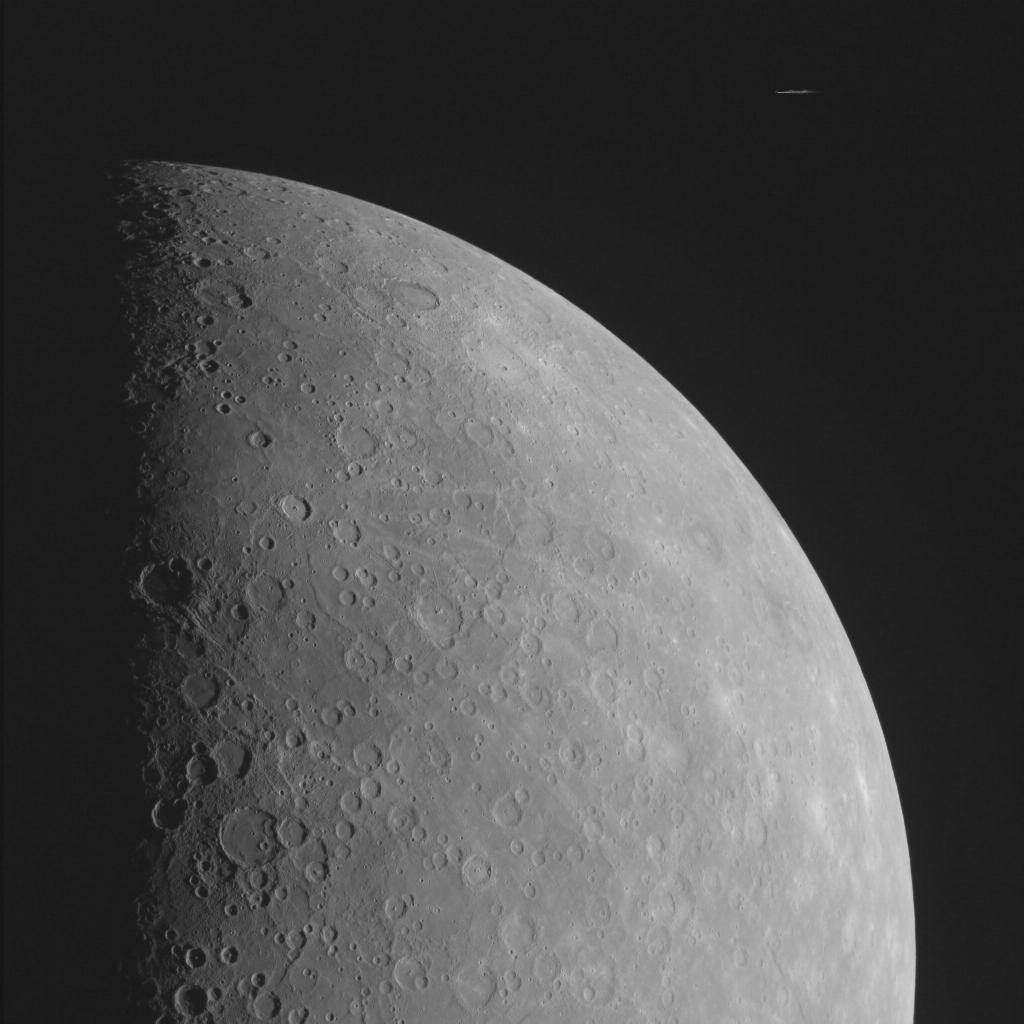

In [10]:
Image(filename='2011_207/Conversion Results/EW0220137668G.IMG.jpg') 

### In the first image, the artefact is at the top right.

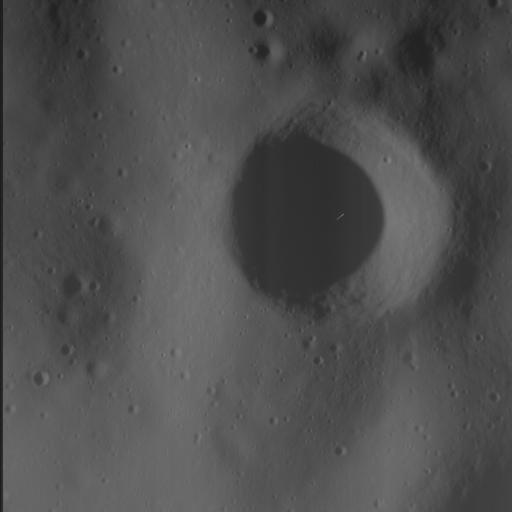

In [11]:
Image(filename='2014_215/Conversion Results/EN1049375684M.IMG.jpg') 

### In the second image, the artefact is the small white streak in the middle of the crater.

-----

## Step 2 – Dataset preparation

- A total of 1,22,789 IMG Files were scraped from the Data Archive at https://pdsimage2.wr.usgs.gov/archive/mess-e_v_h-mdis-2-edr-rawdata-v1.0/MSGRMDS_1001/DATA/

- It was then converted to .JPG Files

- Images were segregated into 2 categoried: "Artefacts" and "Non Artefacts"

- About 98 items are chosen with Artefacts, on which Deep Learning Transforms are applied like horizontal and vertical flip, random rotation, random brightness for Data Augmentation.

- 1,603 items are chosen for "Non Artefacts" so that model can effectively learn to avoid false negatives while looking for artefacts.

- This dataset has been included in the "/Content/CRISMIS_Dataset_v3" directory of the submission.

-----
## Step 3 - Machine Learning Algorithm (Refer "Notebook 2")
-----
##### End of Notebook 1